<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Uplift_202309預測**

1. 資料時間
  * 訓練資料：202306+202308活動（0823週三匯元日7523）/data202306_1.csv
  * 測試資料：202309
  * 驗證資料：

2. 資料進度


#Train

##資料探索

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202309.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [3]:
#Complete datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Load your May data
sep_data = pd.read_csv('/content/data202309.csv', index_col = 0)
sep_data = sep_data.reset_index(drop = True)
#sep_data['換匯發送名單'] = sep_data['換匯發送名單'].astype('str')

##確認模型有學到
sep_data['跨售行為'] = [-1 if x == 0 else x for x in sep_data['跨售行為']]
#sep_data['跨售行為'] = sep_data['跨售行為'].astype('str')
# Split the data into train and validation sets
np.random.seed(9487)
train_data, val_data = train_test_split(sep_data, test_size=0.2, random_state=42)
# Specify the treatment and outcome columns
unino = sep_data['UNINO']
X_names = sep_data.columns.drop(['換匯發送名單','TOTALNTAMOUNT', '跨售行為', 'UNINO'])
X_names
#201 columns

Index(['年齡', '公司戶記號', '性別', '呆帳記號_含信用卡', '客戶年收入', '網路會員記號', '網路使用記號_行動銀行',
       '小mma記號', '網路服務記號', '網路使用記號',
       ...
       '客戶行業別_醫療保健', '客戶行業別_金融業', '客戶行業別_電子業', '對帳單寄送記號_0', '對帳單寄送記號_1',
       '對帳單寄送記號_2', '信用卡VIP客戶註記_Y', '外幣存款記號_Y', '信用卡轉呆記號_Y', '信用卡自動扣款記號_Y'],
      dtype='object', length=201)

In [ ]:
import pandas as pd

# Assuming 'treatment' and 'amount' are your column names
cross_table_train = pd.crosstab(train_data['換匯發送名單'], train_data['跨售行為'])
cross_table_val = pd.crosstab(val_data['換匯發送名單'], val_data['跨售行為'])

# Display the cross tables
print("Cross Table for Training Data:")
print(cross_table_train)

print("\nCross Table for Validation Data:")
print(cross_table_val)


Cross Table for Training Data:
跨售行為        -1     1
換匯發送名單              
0       808932  3133
1        34399   815

Cross Table for Validation Data:
跨售行為        -1    1
換匯發送名單             
0       202396  784
1         8459  181


## CasualML_uplift

* 記錄模型時間及存下模型(CasualML_uplift_202306_1/2/3/4/5.pkl)
* 分別存下T = 0/T = 1

In [6]:
!pip install causalml

  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.1 requires pandas<2.1.4,>=1.5.0, but you have pandas 1.3.5 which is incompatible.
bigframes 0.19.1 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


In [6]:
!pip install duecredit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 8.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import duecredit

from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.metrics import plot_gain, get_cumgain
from sklearn.model_selection import train_test_split

import importlib
print(importlib.metadata.version('causalml') )

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

0.14.1


In [ ]:
##用Subsets跑
import pandas as pd
import random
##Split dataset
random.seed(42)
# Load your May data
#Shuffle the dataset
train_data.sample(frac = 1, random_state = 42).reset_index(drop = True)
#num_subset
num_subset = 5
#subset_size
subset_size = len(train_data)//num_subset

subsets = []
for i in range(num_subset):
  start_idx = i* subset_size
  end_idx = (i+1)* subset_size
  subset = train_data.iloc[start_idx: end_idx]
  subsets.append(subset)

In [ ]:
#節省RAM容量 先將june_data drop掉
import gc
del sep_data
gc.collect()

34

In [ ]:
#1 hr 37 min
%%time
import pickle

for i in range(0,5):
  df = subsets[i]
  df.drop(columns = 'UNINO', inplace = True)
  uplift_model = CausalRandomForestRegressor(control_name=0)

  uplift_model.fit(df[X_names].values,
                 treatment=df['換匯發送名單'].values,
                 y=df['跨售行為'].values)
  print('Finish running uplift_202309_'+ str(i+1))
  #Save model
  # Open a file and use dump()
  with open('/content/drive/MyDrive/Model/CasualML_uplift_202309_'+ str(i+1) + '.pkl', 'wb') as file:
      # A new file will be created
      pickle.dump(uplift_model, file)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finish running uplift_202309_1



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finish running uplift_202309_2



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finish running uplift_202309_3



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finish running uplift_202309_4



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finish running uplift_202309_5
CPU times: user 1h 37s, sys: 49 s, total: 1h 1min 26s
Wall time: 1h 1min 50s


In [ ]:
%%time
df_res = uplift_model.predict(train_data[X_names].values, with_outcomes=True)
print(df_res.shape)
df_res

(847279, 3)
CPU times: user 95 µs, sys: 0 ns, total: 95 µs
Wall time: 99.4 µs


array([[-9.99850218e-01, -1.00000000e+00, -1.49781518e-04],
       [-9.98095805e-01, -9.97039883e-01,  1.05592192e-03],
       [-9.99649123e-01, -1.00000000e+00, -3.50877471e-04],
       ...,
       [-9.99780036e-01, -9.99493671e-01,  2.86364798e-04],
       [-9.99155232e-01, -9.73242820e-01,  2.59124126e-02],
       [-9.99092202e-01, -9.73242820e-01,  2.58493817e-02]])

In [ ]:
#RAM限制無法使用平行方式運算，若環境更好可以考慮加速
%%time
import pickle
import pandas as pd

def load_and_predict(i, df):
    model_path = f"/content/drive/MyDrive/Model/CasualML_uplift_202309_{i}.pkl"
    model = pickle.load(open(model_path, "rb"))
    df_res = model.predict(train_data[X_names].values, with_outcomes=True)
    df[f'Uplift_{i}|T=0'] = df_res[:, 0]
    df[f'Uplift_{i}|T=1'] = df_res[:, 1]
    print(f'Finish running uplift_202309_{i}')
    return df

# 循环运行五个模型
result = pd.DataFrame()
for i in range(1, 6):
    result = load_and_predict(i, result)

# 计算均值
T_cols = [f'Uplift_{i}|T=0' for i in range(1, 6)]
T1_cols = [f'Uplift_{i}|T=1' for i in range(1, 6)]

res = train_data[['UNINO','換匯基因標籤','換匯發送名單','TOTALNTAMOUNT','跨售行為']]
res['Uplift_mean|T=0'] = result[T_cols].mean(axis=1)
res['Uplift_mean|T=1'] = result[T1_cols].mean(axis=1)
res['Uplift_mean'] = res['Uplift_mean|T=1'] - res['Uplift_mean|T=0']

# 结果
res

Finish running uplift_202309_1
Finish running uplift_202309_2
Finish running uplift_202309_3
Finish running uplift_202309_4
Finish running uplift_202309_5
CPU times: user 2min 12s, sys: 3.96 s, total: 2min 15s
Wall time: 2min 23s



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
457551,H8225993450,62.5926,0,0,-1,-0.999875,-0.997675,0.002200
565995,J2750863690,77.9054,0,0,-1,-0.999884,-0.995941,0.003943
258766,H1782646640,67.6935,0,0,-1,-0.999693,-0.993156,0.006537
38205,A2527929550,77.9133,1,0,-1,-0.999243,-0.994968,0.004275
268669,F2793340610,94.4490,0,0,-1,-0.998446,-0.999422,-0.000975
...,...,...,...,...,...,...,...,...
110268,F1746010820,71.7632,0,0,-1,-0.990456,-0.982372,0.008084
259178,F2754533130,96.4844,0,0,-1,-0.999484,-0.994234,0.005249
131932,F1511072300,70.9035,0,0,-1,-0.996210,-0.995338,0.000872
671155,S1795484550,70.2565,0,0,-1,-0.996019,-0.989495,0.006524


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv')
#847279 rows × 8 columns

In [ ]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv', index_col = 0)
res

,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1",Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te_2
0,95.6573,0.0,0.0,0.0,0.003857,171877.611205,-15491.582082,156386.029123,0.004392,0.030030,0.025638,0.008651
1,51.2266,0.0,0.0,0.0,0.005216,60231.893431,-16702.654345,43529.239086,0.003726,0.036421,0.032695,0.012721
2,0.0000,0.0,0.0,0.0,0.088081,185014.157793,-18722.602433,166291.555359,0.004439,0.029362,0.024923,0.002097
3,92.5319,0.0,0.0,0.0,0.009854,105375.134061,-16844.181767,88530.952295,0.004514,0.035176,0.030661,0.012487
4,72.7368,0.0,0.0,0.0,0.004691,134203.240261,-17052.090107,117151.150154,0.004213,0.036763,0.032550,0.010406
...,...,...,...,...,...,...,...,...,...,...,...,...
842527,87.0161,0.0,0.0,0.0,0.003217,92797.450155,-11850.765296,80946.684859,0.005313,0.038764,0.033451,0.005785
842528,34.3924,0.0,0.0,0.0,0.006865,100339.262909,-12616.243079,87723.019830,0.002986,0.045579,0.042592,0.014847
842529,10.1501,0.0,0.0,0.0,0.004856,95744.788643,-16623.983587,79120.805056,0.001671,0.059648,0.057978,0.011749
842530,90.5030,0.0,0.0,0.0,0.003267,112106.141114,-18647.786641,93458.354472,0.003954,0.035925,0.031971,0.008392


##X_Learner

In [2]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 36.3 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.44.0
    Uninstalling shap-0.44.0:
      Successfully uninstalled shap-0.44.0


In [11]:
!pip install --upgrade DecisionTreeClassifier
!pip install scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.1 requires pandas<2.1.4,>=1.5.0, but you have pandas 1.3.5 which is incompatible.
causalml 0.14.1 requires scikit-learn<=1.0.2, but you have scikit-learn 1.2.2 which is incompatible.


In [4]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# Helper imports
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
%%time
df = train_data

# Instantiate X learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6)
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6)
X_learner = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y=df['跨售行為'].values, T = df['換匯發送名單'].values, X=df[X_names].values)

In [ ]:
#Save model
import pickle
#Open a file and use dump()
with open('/content/drive/MyDrive/Model/EconML_X_202309.pkl', 'wb') as file:
    pickle.dump(X_learner, file)

In [15]:
#Load model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/EconML_X_202309.pkl', 'rb') as file:
    # A new file will be created
    X_learner = pickle.load(file)

Trying to unpickle estimator DummyRegressor from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator DecisionTreeRegressor from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GradientBoostingRegressor from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.0.2. 

In [ ]:
# Estimate treatment effects on test data
X = X_learner.effect(train_data[X_names])
X

array([-1.86112779e-06, -8.39421483e-06,  6.38739905e-05, ...,
       -9.24899132e-06, -1.73756609e-04,  2.27741449e-04])

In [ ]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
457551,H8225993450,62.5926,0,0,-1,-0.999875,-0.997675,0.002200
565995,J2750863690,77.9054,0,0,-1,-0.999884,-0.995941,0.003943
258766,H1782646640,67.6935,0,0,-1,-0.999693,-0.993156,0.006537
38205,A2527929550,77.9133,1,0,-1,-0.999243,-0.994968,0.004275
268669,F2793340610,94.4490,0,0,-1,-0.998446,-0.999422,-0.000975
...,...,...,...,...,...,...,...,...
110268,F1746010820,71.7632,0,0,-1,-0.990456,-0.982372,0.008084
259178,F2754533130,96.4844,0,0,-1,-0.999484,-0.994234,0.005249
131932,F1511072300,70.9035,0,0,-1,-0.996210,-0.995338,0.000872
671155,S1795484550,70.2565,0,0,-1,-0.996019,-0.989495,0.006524


In [ ]:
res['X_te'] = X
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv')

##One stage X_Learner

In [ ]:
# Main imports
from econml.metalearners import XLearner

# Helper imports
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [ ]:
%%time
df = train_data

# Instantiate X learner (2 hr 5 min)
models = GradientBoostingRegressor(n_estimators=100, max_depth=6)
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6)
X_learner_value = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner_value.fit(Y=df['TOTALNTAMOUNT'].values, T = df['換匯發送名單'].values, X=df[X_names].values)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


CPU times: user 2h 20min 23s, sys: 14.9 s, total: 2h 20min 38s
Wall time: 2h 21min 15s


In [ ]:
#Save model

import pickle
#Open a file and use dump()
with open('/content/drive/MyDrive/Model/Value_EconML_X_202309.pkl', 'wb') as file:
    pickle.dump(X_learner_value, file)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Value_EconML_X_202309.pkl', 'rb') as file:
    # A new file will be created
    X_learner_value = pickle.load(file)

In [ ]:
# Estimate treatment effects on test data
X = X_learner_value.effect(train_data[X_names])
X

array([15.32790037, 14.64198439, 14.50143351, ..., 14.57855277,
       14.54705592, 14.4839171 ])

In [ ]:
res['Value_X'] = X
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv')
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X
457551,H8225993450,62.5926,0,0,-1,-0.999875,-0.997675,0.002200,-0.000002,15.327900
565995,J2750863690,77.9054,0,0,-1,-0.999884,-0.995941,0.003943,-0.000008,14.641984
258766,H1782646640,67.6935,0,0,-1,-0.999693,-0.993156,0.006537,0.000064,14.501434
38205,A2527929550,77.9133,1,0,-1,-0.999243,-0.994968,0.004275,0.000081,17.411339
268669,F2793340610,94.4490,0,0,-1,-0.998446,-0.999422,-0.000975,-0.000392,-89.759552
...,...,...,...,...,...,...,...,...,...,...
110268,F1746010820,71.7632,0,0,-1,-0.990456,-0.982372,0.008084,-0.000009,14.434745
259178,F2754533130,96.4844,0,0,-1,-0.999484,-0.994234,0.005249,-0.002326,27.665152
131932,F1511072300,70.9035,0,0,-1,-0.996210,-0.995338,0.000872,-0.000009,14.578553
671155,S1795484550,70.2565,0,0,-1,-0.996019,-0.989495,0.006524,-0.000174,14.547056


## EconML_RF

* 紀錄金額(profit)模型

In [ ]:
#62282
deal_train  = train_data[train_data['跨售行為']==1]
deal_val = val_data[val_data['跨售行為']==1]
#deal_train['換匯發送名單'] = deal_train['換匯發送名單'].astype('float')
deal_train
#3948 rows × 205 columns

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
156174,F1751288320,48,0,1.0,0,600.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,1
33194,C1792020900,42,0,1.0,0,600.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
371726,H2771378790,43,0,2.0,0,800.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
291595,F2779707170,54,0,2.0,0,0.0,1,1,0,3,...,0,0,0,0,0,1,0,1,0,0
14617,B2771326380,51,0,2.0,0,2065.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860395,A1718890690,38,0,1.0,0,1000.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,1
220984,F2522092670,23,0,2.0,0,110.0,1,2,0,1,...,1,0,0,0,0,1,0,1,0,0
687995,S1738091190,25,0,1.0,0,800.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
128391,F1717337110,39,0,1.0,0,800.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
!pip install econml

In [ ]:
import numpy as np
import pandas as pd

import os
import urllib.request

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# EconML imports
from econml.grf import RegressionForest, CausalForest
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

import importlib
print(importlib.metadata.version('econml') )

0.14.1


In [ ]:
deal_train['換匯發送名單'] = deal_train['換匯發送名單'].astype('float')
df = deal_train[deal_train['換匯發送名單']==0]
df
#3133 rows × 205 columns


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
156174,F1751288320,48,0,1.0,0,600.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,1
33194,C1792020900,42,0,1.0,0,600.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
371726,H2771378790,43,0,2.0,0,800.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
291595,F2779707170,54,0,2.0,0,0.0,1,1,0,3,...,0,0,0,0,0,1,0,1,0,0
14617,B2771326380,51,0,2.0,0,2065.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817052,A1752164460,55,0,1.0,0,2000.0,1,2,0,1,...,0,0,0,1,0,0,1,1,0,1
293894,F2726753310,51,0,2.0,1,300.0,1,1,0,1,...,0,0,0,0,0,1,0,1,1,0
220984,F2522092670,23,0,2.0,0,110.0,1,2,0,1,...,1,0,0,0,0,1,0,1,0,0
687995,S1738091190,25,0,1.0,0,800.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
%%time
#CPU times: user 56.6 s, sys: 184 ms, total: 56.7 s
#Wall time: 50.5 s
#RegressionForest(n_estimators=400, random_state=1235)
est_2 = RegressionForest(n_estimators=400, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=0, n_jobs=-1, random_state=1235)

est_2.fit(X = df[X_names].values, y = df['TOTALNTAMOUNT'].values)

CPU times: user 29.9 s, sys: 132 ms, total: 30 s
Wall time: 34.6 s


RegressionForest(n_estimators=400, random_state=1235)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_RF_202309.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(est_2, file)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_RF_202304_1.pkl', 'rb') as file:
    # A new file will be created
    est_2 = pickle.load(file)

In [ ]:
t_pred = est_2.predict(train_data[X_names])
t_pred

array([[849.18242946],
       [854.48563372],
       [849.74880067],
       ...,
       [847.13837337],
       [852.22265617],
       [854.19621489]])

##EconML_CFDML

In [ ]:
df = deal_train

In [ ]:
%%time
# Train EconML model
#CPU times: user 4min 7s, sys: 770 ms, total: 4min 8s
#Wall time: 3min 21s

# Initialize and fit the CausalForestDML model with discrete treatment
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from econml.dml import CausalForestDML

est = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
                       random_state=123)

# Fit the model to your data
est.tune(Y=df['TOTALNTAMOUNT'].values, T=df['換匯發送名單'].values, X=df[X_names].values)
est.fit(Y=df['TOTALNTAMOUNT'].values, T=df['換匯發送名單'].values, X=df[X_names].values)

CPU times: user 5min 31s, sys: 1.02 s, total: 5min 32s
Wall time: 3min 52s


In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_CF_202309.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(est, file)

In [ ]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_CF_202304_1.pkl', 'rb') as file:
    # A new file will be created
    est = pickle.load(file)

In [ ]:
# Get treatment effect and its confidence interval
te_pred = est.effect(train_data[X_names])
te_pred
#array([34889.1509029 , 33831.79008391, 49974.03768858, ...,
#       28758.54341653, 35872.75946227, 30689.87590191])

array([-4687.70098285, -3799.97626337,   141.06613468, ...,
        1947.94340523,    43.31220492,   970.00014682])

In [ ]:
#res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv', index_col = 0)
res['E(V)|T = 0, D = 1'] = t_pred
res['te'] = te_pred
res['E(V)|T = 1, D = 1'] = res['E(V)|T = 0, D = 1'] + res['te']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
457551,H8225993450,62.5926,0,0,-1,-0.999875,-0.997675,0.002200,-0.000002,15.327900,849.182429,-4687.700983,-3838.518553
565995,J2750863690,77.9054,0,0,-1,-0.999884,-0.995941,0.003943,-0.000008,14.641984,854.485634,-3799.976263,-2945.490630
258766,H1782646640,67.6935,0,0,-1,-0.999693,-0.993156,0.006537,0.000064,14.501434,849.748801,141.066135,990.814935
38205,A2527929550,77.9133,1,0,-1,-0.999243,-0.994968,0.004275,0.000081,17.411339,843.225230,174.708636,1017.933867
268669,F2793340610,94.4490,0,0,-1,-0.998446,-0.999422,-0.000975,-0.000392,-89.759552,875.894064,-234.119552,641.774511
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,F1746010820,71.7632,0,0,-1,-0.990456,-0.982372,0.008084,-0.000009,14.434745,850.989275,458.143273,1309.132548
259178,F2754533130,96.4844,0,0,-1,-0.999484,-0.994234,0.005249,-0.002326,27.665152,870.248212,341.542110,1211.790322
131932,F1511072300,70.9035,0,0,-1,-0.996210,-0.995338,0.000872,-0.000009,14.578553,847.138373,1947.943405,2795.081779
671155,S1795484550,70.2565,0,0,-1,-0.996019,-0.989495,0.006524,-0.000174,14.547056,852.222656,43.312205,895.534861


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv')
#847279 rows × 13 columns

###Plot

In [ ]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_training_202309_results.csv', index_col = 0)
res

,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1",Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te_2,Value_X
0,95.6573,0.0,0.0,0.0,0.003857,171877.611205,-15491.582082,156386.029123,0.004392,0.030030,0.025638,0.008651,1352.730902
1,51.2266,0.0,0.0,0.0,0.005216,60231.893431,-16702.654345,43529.239086,0.003726,0.036421,0.032695,0.012721,226.204003
2,0.0000,0.0,0.0,0.0,0.088081,185014.157793,-18722.602433,166291.555359,0.004439,0.029362,0.024923,0.002097,386.355066
3,92.5319,0.0,0.0,0.0,0.009854,105375.134061,-16844.181767,88530.952295,0.004514,0.035176,0.030661,0.012487,415.973861
4,72.7368,0.0,0.0,0.0,0.004691,134203.240261,-17052.090107,117151.150154,0.004213,0.036763,0.032550,0.010406,491.336279
...,...,...,...,...,...,...,...,...,...,...,...,...,...
842527,87.0161,0.0,0.0,0.0,0.003217,92797.450155,-11850.765296,80946.684859,0.005313,0.038764,0.033451,0.005785,241.293678
842528,34.3924,0.0,0.0,0.0,0.006865,100339.262909,-12616.243079,87723.019830,0.002986,0.045579,0.042592,0.014847,225.191728
842529,10.1501,0.0,0.0,0.0,0.004856,95744.788643,-16623.983587,79120.805056,0.001671,0.059648,0.057978,0.011749,223.694338
842530,90.5030,0.0,0.0,0.0,0.003267,112106.141114,-18647.786641,93458.354472,0.003954,0.035925,0.031971,0.008392,769.662736


In [ ]:
train = res.iloc[:,:5]
train['X_te'] = res['X_te']
train['E(V)|T = 0, D = 1'] = res['E(V)|T = 0, D = 1']* res['Uplift_mean|T=0']
train['E(V)|T = 1, D = 1'] = res['E(V)|T = 1, D = 1']* res['Uplift_mean|T=1']
train['Gi'] = train['E(V)|T = 1, D = 1']-train['E(V)|T = 0, D = 1']
train

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi
457551,H8225993450,62.5926,0,0,-1,-0.000002,-849.076138,3829.593797,4678.669934
565995,J2750863690,77.9054,0,0,-1,-0.000008,-854.386275,2933.534417,3787.920692
258766,H1782646640,67.6935,0,0,-1,0.000064,-849.487971,-984.034250,-134.546279
38205,A2527929550,77.9133,1,0,-1,0.000081,-842.587105,-1012.811501,-170.224396
268669,F2793340610,94.4490,0,0,-1,-0.000392,-874.533338,-641.403249,233.130090
...,...,...,...,...,...,...,...,...,...
110268,F1746010820,71.7632,0,0,-1,-0.000009,-842.867112,-1286.054790,-443.187678
259178,F2754533130,96.4844,0,0,-1,-0.002326,-869.799062,-1204.803633,-335.004572
131932,F1511072300,70.9035,0,0,-1,-0.000009,-843.927956,-2782.052501,-1938.124546
671155,S1795484550,70.2565,0,0,-1,-0.000174,-848.830375,-886.127377,-37.297003


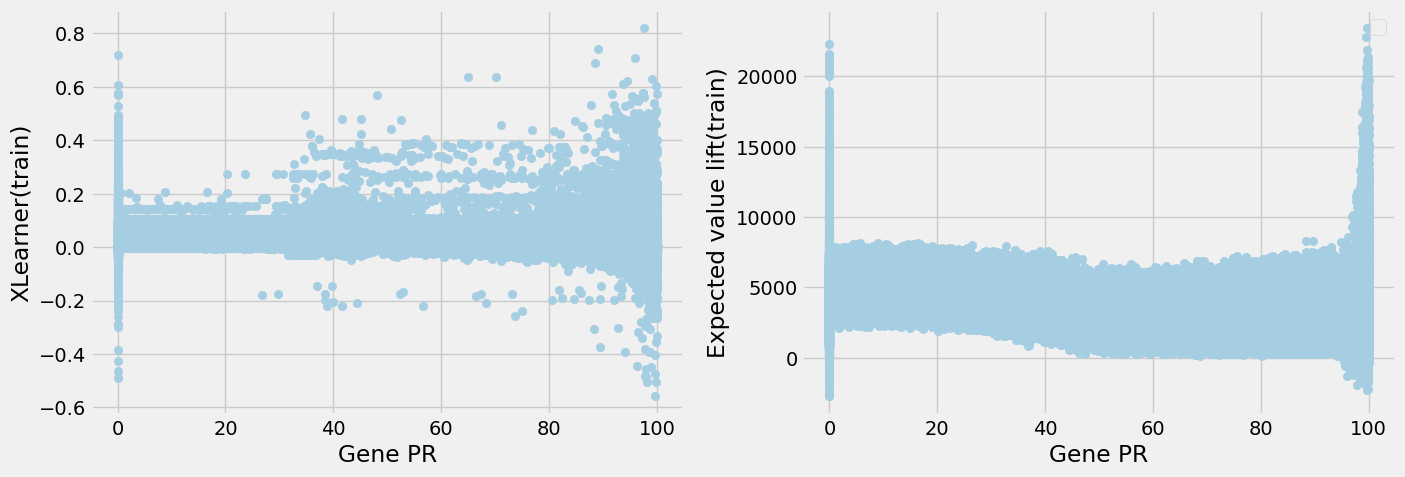

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(res.iloc[:,0], res['X_te'], label="Uplift")
plt.xlabel('Gene PR')
plt.ylabel('XLearner(train)')
plt.subplot(122)
plt.scatter(res.iloc[:,0],train['Gi'])
plt.xlabel('Gene PR')
plt.ylabel('Expected value lift(train)')
plt.legend()

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','跨售行為',	'Uplift_mean']]
auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=42)

Uplift_mean    16628.908928
Random         16303.870523
dtype: float64

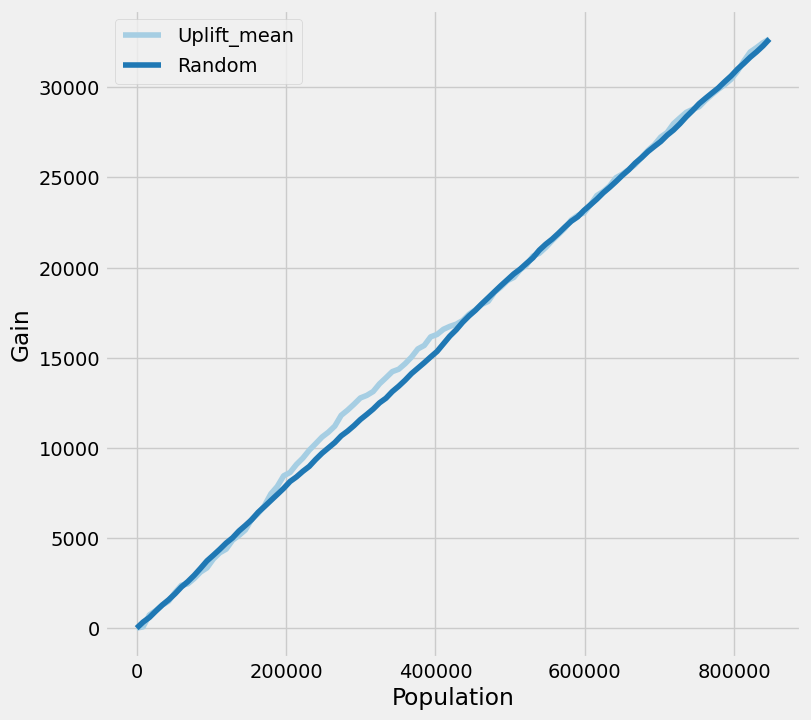

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = res
T =T[['換匯發送名單','跨售行為',	'Uplift_mean']]
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=10)

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','跨售行為',	'X_te']]
auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=42)

X_te      38275.491565
Random    16303.870523
dtype: float64

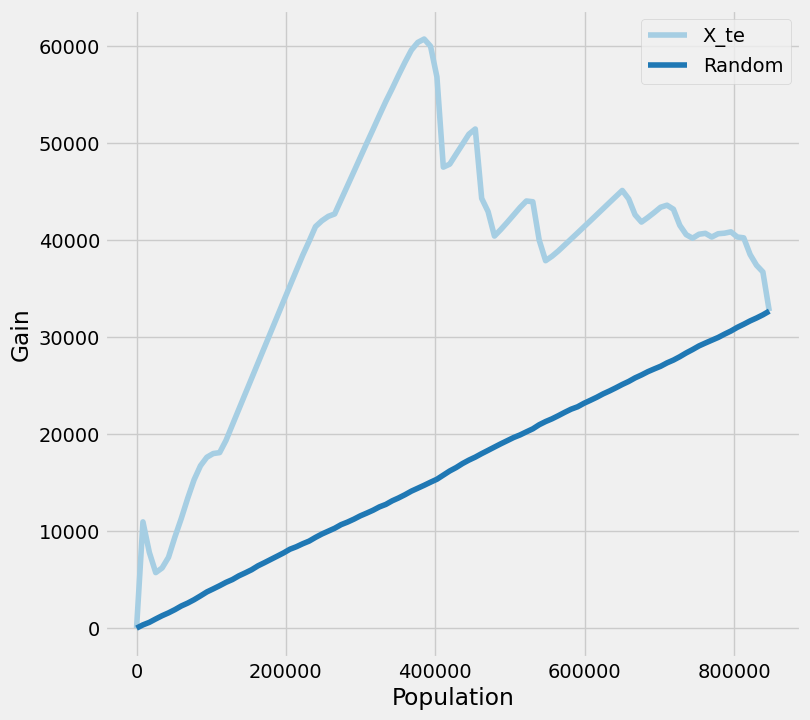

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = res
T =T[['換匯發送名單','跨售行為',	'X_te']]
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=10)

Value_X    8.146960e+08
Random     7.370523e+08
dtype: float64


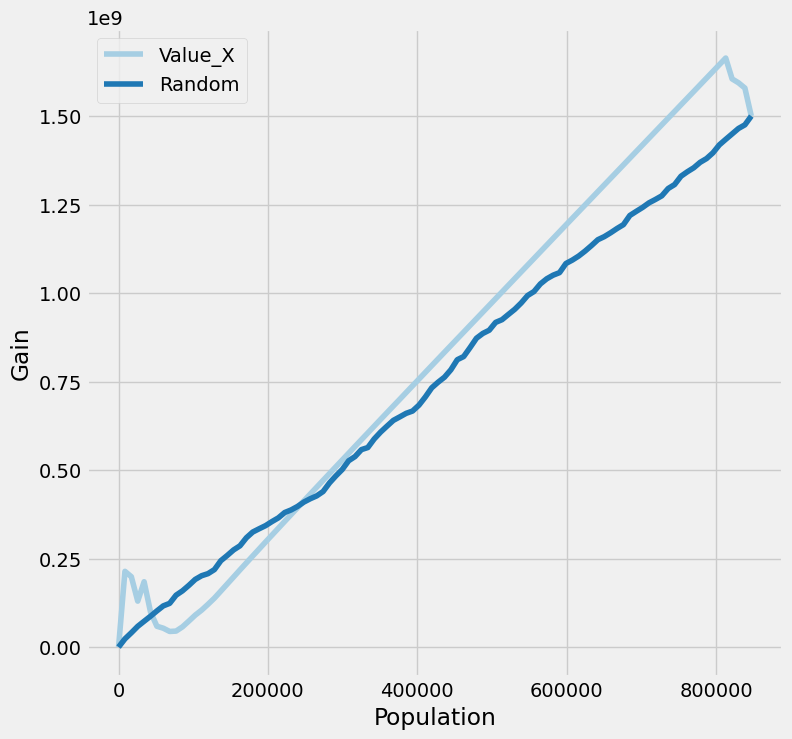

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','TOTALNTAMOUNT',	'Value_X']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=42))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=10)

Gi        4.354172e+08
Random    7.370523e+08
dtype: float64


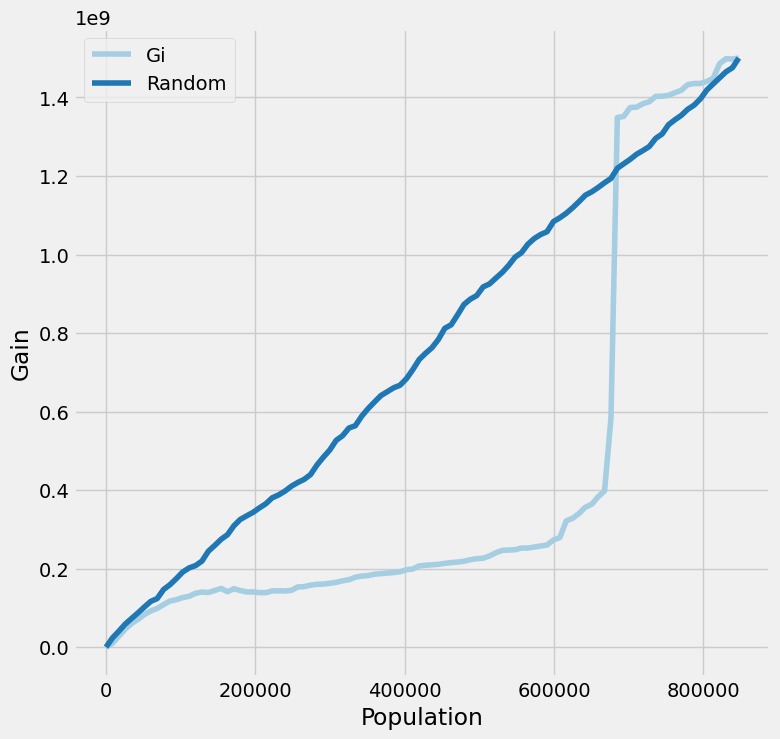

In [ ]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =train[['換匯發送名單','TOTALNTAMOUNT',	'Gi']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=42))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=False, random_seed=10)

#Validation

In [8]:
#RAM限制無法使用平行方式運算，若環境更好可以考慮加速
%%time
import pickle
import pandas as pd

def load_and_predict(i, df):
    model_path = f"/content/drive/MyDrive/Model/CasualML_uplift_202309_{i}.pkl"
    model = pickle.load(open(model_path, "rb"))
    df_res = model.predict(val_data[X_names].values, with_outcomes=True)
    df[f'Uplift_{i}|T=0'] = df_res[:, 0]
    df[f'Uplift_{i}|T=1'] = df_res[:, 1]
    print(f'Finish running uplift_202309_{i}')
    return df

# 循环运行五个模型
result = pd.DataFrame()
for i in range(1, 6):
    result = load_and_predict(i, result)

# 计算均值
T_cols = [f'Uplift_{i}|T=0' for i in range(1, 6)]
T1_cols = [f'Uplift_{i}|T=1' for i in range(1, 6)]

res = val_data[['UNINO','換匯基因標籤','換匯發送名單','TOTALNTAMOUNT','跨售行為']].reset_index()
res['Uplift_mean|T=0'] = result[T_cols].mean(axis=1)
res['Uplift_mean|T=1'] = result[T1_cols].mean(axis=1)
res['Uplift_mean'] = res['Uplift_mean|T=1'] - res['Uplift_mean|T=0']

# 结果
res

CPU times: user 40 µs, sys: 0 ns, total: 40 µs
Wall time: 45.3 µs


,index,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean
0,444309,L2718876160,71.3226,0,0,-1,-0.995325,-0.996728,-0.001403
1,517481,N2724881730,29.8271,0,0,-1,-0.999824,-0.993319,0.006505
2,849755,B1799016720,51.4779,0,0,-1,-0.999824,-0.993319,0.006505
3,57088,C1799144080,63.5834,0,0,-1,-0.999443,-0.998630,0.000813
4,832560,Y1721195810,86.3273,0,0,-1,-0.992592,-0.989825,0.002768
...,...,...,...,...,...,...,...,...,...
211815,84996,D1793263990,52.9331,0,0,-1,-0.999824,-0.993319,0.006505
211816,784156,T2711975880,75.7352,0,0,-1,-0.993126,-0.988771,0.004355
211817,182875,F1700999350,62.4016,0,0,-1,-0.999345,-1.000000,-0.000655
211818,256672,F1749270570,48.0369,0,0,-1,-0.999885,-0.995941,0.003944


In [5]:
#Load model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/EconML_X_202309.pkl', 'rb') as file:
    # A new file will be created
    X_learner = pickle.load(file)

In [6]:
# Estimate treatment effects on test data
X_te = X_learner.effect(val_data[X_names])
X_te

array([1.09198452e-04, 3.01121903e-04, 3.00916648e-04, ...,
       2.27914883e-04, 6.38033281e-05, 3.17264941e-04])

In [7]:
#Save model
import pickle
#Value_EconML_X_202304.pkl One stage X Learner
with open('/content/drive/MyDrive/Model/Value_EconML_X_202309.pkl', 'rb') as file:
    # A new file will be created
    X_learner_value = pickle.load(file)

In [8]:
# Estimate treatment effects on test data
X = X_learner_value.effect(val_data[X_names])
X

array([14.87391451, 14.42160184, 14.43895027, ..., 14.46743354,
       14.50793916, 14.44404642])

In [9]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_RF_202309.pkl', 'rb') as file:
    # A new file will be created
    est_2 = pickle.load(file)

In [10]:
t_pred = est_2.predict(val_data[X_names])
t_pred

array([[846.89503919],
       [849.50605659],
       [851.28713732],
       ...,
       [850.9564905 ],
       [849.77242946],
       [851.01621119]])

In [12]:
#Save model
import pickle
# Open a file and use dump()
with open('/content/drive/MyDrive/Model/Econml_CF_202309.pkl', 'rb') as file:
    est = pickle.load(file)

In [13]:
# Get treatment effect and its confidence interval
te_pred = est.effect(val_data[X_names])
te_pred

array([  -46.40297412,  -365.47854923,   825.55868042, ...,
       -4412.07648875,   640.46910946,  2367.47457934])

In [26]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202309_results.csv', index_col = 0)
res['X_te'] = X_te
res['Value_X'] = X
res['E(V)|T = 0, D = 1'] = t_pred
res['te'] = te_pred
res['E(V)|T = 1, D = 1'] = res['E(V)|T = 0, D = 1'] + res['te']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
0,L2718876160,71.3226,0,0,-1,-0.995325,-0.996728,-0.001403,0.000109,14.873915,846.895039,-46.402974,800.492065
1,N2724881730,29.8271,0,0,-1,-0.999824,-0.993319,0.006505,0.000301,14.421602,849.506057,-365.478549,484.027507
2,B1799016720,51.4779,0,0,-1,-0.999824,-0.993319,0.006505,0.000301,14.438950,851.287137,825.558680,1676.845818
3,C1799144080,63.5834,0,0,-1,-0.999443,-0.998630,0.000813,0.000225,15.057341,854.156800,30.064906,884.221706
4,Y1721195810,86.3273,0,0,-1,-0.992592,-0.989825,0.002768,0.000502,16.078111,843.453993,314.037629,1157.491622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211815,D1793263990,52.9331,0,0,-1,-0.999824,-0.993319,0.006505,0.000301,14.430565,851.287137,4361.632648,5212.919785
211816,T2711975880,75.7352,0,0,-1,-0.993126,-0.988771,0.004355,-0.000008,14.601819,847.401349,-113.057550,734.343798
211817,F1700999350,62.4016,0,0,-1,-0.999345,-1.000000,-0.000655,0.000228,14.467434,850.956490,-4412.076489,-3561.119998
211818,F1749270570,48.0369,0,0,-1,-0.999885,-0.995941,0.003944,0.000064,14.507939,849.772429,640.469109,1490.241539


In [27]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202309_results.csv')
#211820 rows × 13 columns

In [8]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202309_results.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,Uplift_mean|T=0,Uplift_mean|T=1,Uplift_mean,X_te,Value_X,"E(V)|T = 0, D = 1",te,"E(V)|T = 1, D = 1"
0,L2718876160,71.3226,0,0,-1,-0.995325,-0.996728,-0.001403,0.000109,14.873915,846.895039,-46.402974,800.492065
1,N2724881730,29.8271,0,0,-1,-0.999824,-0.993319,0.006505,0.000301,14.421602,849.506057,-365.478549,484.027507
2,B1799016720,51.4779,0,0,-1,-0.999824,-0.993319,0.006505,0.000301,14.438950,851.287137,825.558680,1676.845818
3,C1799144080,63.5834,0,0,-1,-0.999443,-0.998630,0.000813,0.000225,15.057341,854.156800,30.064906,884.221706
4,Y1721195810,86.3273,0,0,-1,-0.992592,-0.989825,0.002768,0.000502,16.078111,843.453993,314.037629,1157.491622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211815,D1793263990,52.9331,0,0,-1,-0.999824,-0.993319,0.006505,0.000301,14.430565,851.287137,4361.632648,5212.919785
211816,T2711975880,75.7352,0,0,-1,-0.993126,-0.988771,0.004355,-0.000008,14.601819,847.401349,-113.057550,734.343798
211817,F1700999350,62.4016,0,0,-1,-0.999345,-1.000000,-0.000655,0.000228,14.467434,850.956490,-4412.076489,-3561.119998
211818,F1749270570,48.0369,0,0,-1,-0.999885,-0.995941,0.003944,0.000064,14.507939,849.772429,640.469109,1490.241539


In [29]:
val = res.iloc[:,:5]
val['X_te'] = res['X_te']
val['Uplift_mean'] = res['Uplift_mean']
val['E(V)|T = 0, D = 1'] = res['E(V)|T = 0, D = 1']* res['Uplift_mean|T=0']
val['E(V)|T = 1, D = 1'] = res['E(V)|T = 1, D = 1']* res['Uplift_mean|T=1']
val['Gi'] = val['E(V)|T = 1, D = 1']-val['E(V)|T = 0, D = 1']
val['Value_X'] = res['Value_X']
#res['Value_mean'] = pred['Value_mean']
val

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,Uplift_mean,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi,Value_X
0,L2718876160,71.3226,0,0,-1,0.000109,-0.001403,-842.935671,-797.873118,45.062553,14.873915
1,N2724881730,29.8271,0,0,-1,0.000301,0.006505,-849.356829,-480.793873,368.562955,14.421602
2,B1799016720,51.4779,0,0,-1,0.000301,0.006505,-851.137597,-1665.643344,-814.505747,14.438950
3,C1799144080,63.5834,0,0,-1,0.000225,0.000813,-853.681320,-883.010712,-29.329392,15.057341
4,Y1721195810,86.3273,0,0,-1,0.000502,0.002768,-837.205995,-1145.713870,-308.507875,16.078111
...,...,...,...,...,...,...,...,...,...,...,...
211815,D1793263990,52.9331,0,0,-1,0.000301,0.006505,-851.137597,-5178.093925,-4326.956329,14.430565
211816,T2711975880,75.7352,0,0,-1,-0.000008,0.004355,-841.576124,-726.097783,115.478341,14.601819
211817,F1700999350,62.4016,0,0,-1,0.000228,-0.000655,-850.399423,3561.119998,4411.519422,14.467434
211818,F1749270570,48.0369,0,0,-1,0.000064,0.003944,-849.674608,-1484.192413,-634.517804,14.507939


In [2]:
import pandas as pd
#val.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202309_results_all.csv')
val = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202309_results_all.csv', index_col = 0)
val

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,Uplift_mean,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi,Value_X
0,L2718876160,71.3226,0,0,-1,0.000109,-0.001403,-842.935671,-797.873118,45.062553,14.873915
1,N2724881730,29.8271,0,0,-1,0.000301,0.006505,-849.356829,-480.793873,368.562955,14.421602
2,B1799016720,51.4779,0,0,-1,0.000301,0.006505,-851.137597,-1665.643344,-814.505747,14.438950
3,C1799144080,63.5834,0,0,-1,0.000225,0.000813,-853.681320,-883.010712,-29.329392,15.057341
4,Y1721195810,86.3273,0,0,-1,0.000502,0.002768,-837.205995,-1145.713870,-308.507875,16.078111
...,...,...,...,...,...,...,...,...,...,...,...
211815,D1793263990,52.9331,0,0,-1,0.000301,0.006505,-851.137597,-5178.093925,-4326.956329,14.430565
211816,T2711975880,75.7352,0,0,-1,-0.000008,0.004355,-841.576124,-726.097783,115.478341,14.601819
211817,F1700999350,62.4016,0,0,-1,0.000228,-0.000655,-850.399423,3561.119998,4411.519422,14.467434
211818,F1749270570,48.0369,0,0,-1,0.000064,0.003944,-849.674608,-1484.192413,-634.517804,14.507939


###Plot

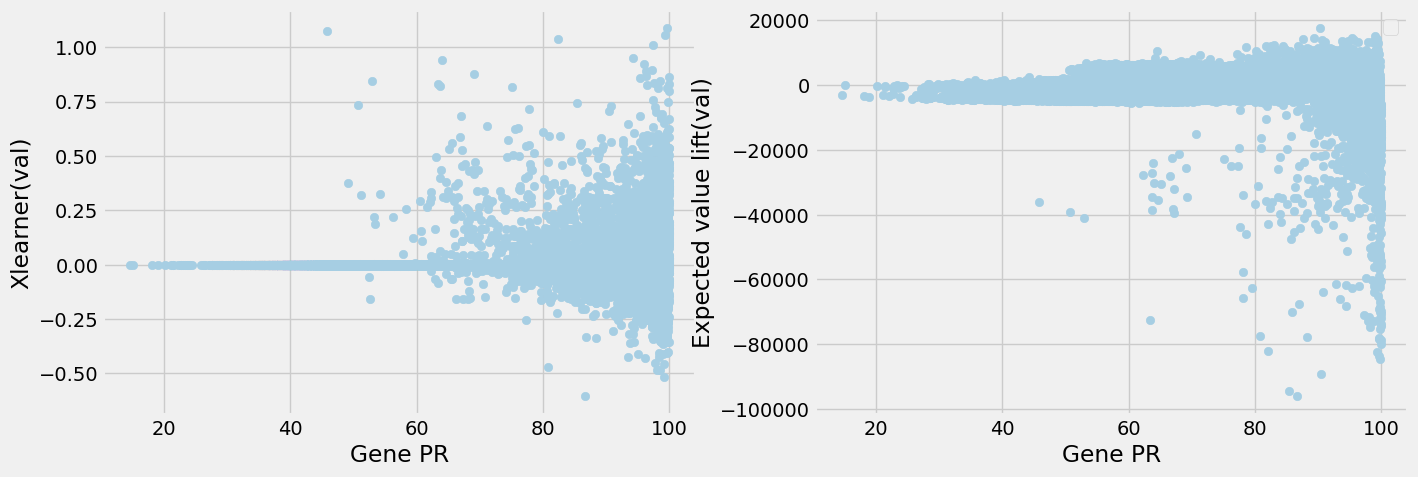

In [5]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(val.iloc[:,1], val['X_te'])
plt.xlabel('Gene PR')
plt.ylabel('Xlearner(val)')
plt.subplot(122)
plt.scatter(val.iloc[:,1], val['Gi'])
plt.xlabel('Gene PR')
plt.ylabel('Expected value lift(val)')
plt.legend()

In [4]:
from causalml.metrics import plot_gain, get_cumgain
T = val
T =T[['換匯發送名單','跨售行為',	'X_te']]
cumgain = get_cumgain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=42)
cumgain

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

,X_te,Random
0,0.000000,0.000000
1,-0.017544,0.000000
2,-0.070175,0.000000
3,-0.157895,0.000000
4,-0.280702,0.000000
...,...,...
211816,7240.019407,7240.122939
211817,7240.061633,7240.165166
211818,7240.103859,7240.103859
211819,7240.146086,7240.146086


Uplift_mean    4796.375339
Random         3604.047137
dtype: float64


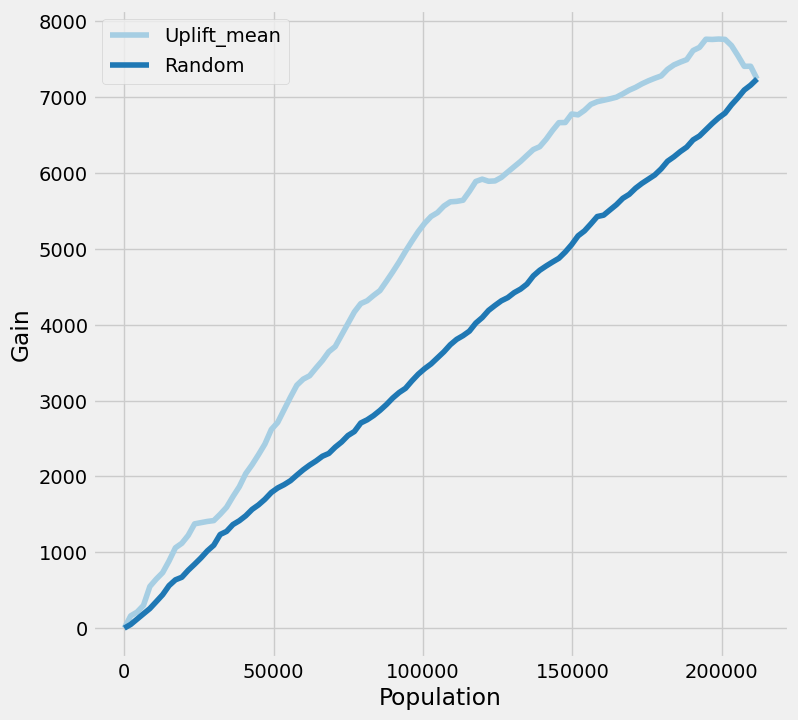

In [11]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T = res
T =T[['換匯發送名單','跨售行為',	'Uplift_mean']]
print(auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22))
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22)

X_te      3985.532519
Random    3604.047137
dtype: float64


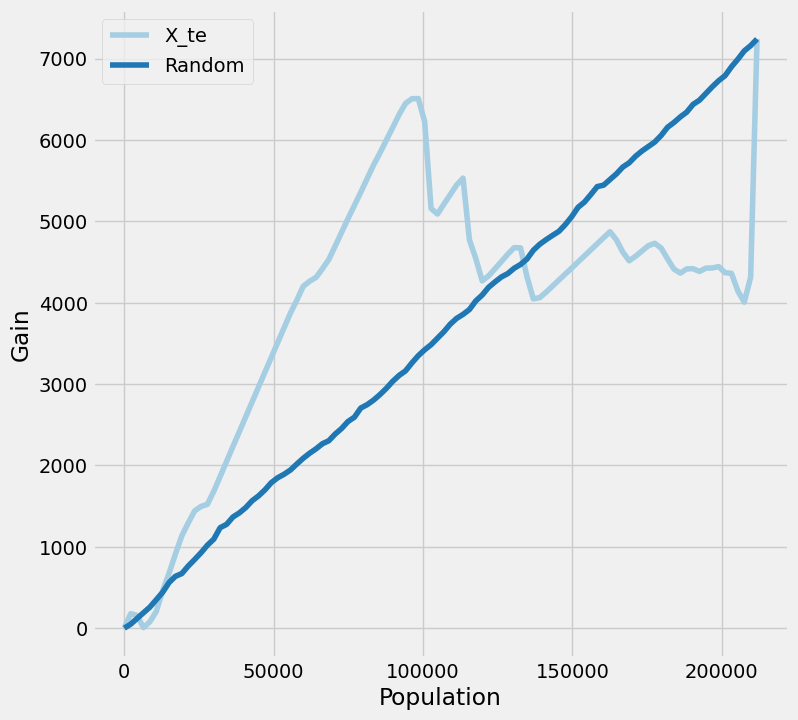

In [12]:
from causalml.metrics import plot_gain, get_cumgain
T = res[['換匯發送名單','跨售行為',	'X_te']]
print(auuc_score(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22))
plot_gain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=False, random_seed=22)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 根据不同列值排序的字典
columns_to_sort = {
    "Uplift_mean": "Uplift_mean",
   "X_te": "X_te",
   "X_te_2": "X_te_2"
}

# 计算Lift值的百分位数
percentiles = range(10, 110, 10)

# 创建字典用于存储不同列的成交率
conversion_rates = {column: [] for column in columns_to_sort}

for col, label in columns_to_sort.items():
   for percentile in percentiles:
       lower_bound = np.percentile(val[col], percentile - 10)
       upper_bound = np.percentile(val[col], percentile)
       subset = val[(val[col] <= upper_bound) & (val[col] > lower_bound)]
       conversion_rate = (subset[col].sum() / len(subset)) * 100
       conversion_rates[label].append(conversion_rate)

# 前5000人跨售金額平均
S = val['跨售行為'].sort_values(ascending=False)[:5000].mean()

# 绘制折线图
fig, ax = plt.subplots()
for label, rates in conversion_rates.items():
   ax.plot(percentiles, rates, label=label)

ax.hlines(y=S, xmin=0.0, xmax=100, color='grey', label='Mean Conversion Rates of first 5000 people')
plt.legend(fontsize=10, loc="upper right")
plt.xlabel("Lift Percentile")
plt.ylabel("Deal Rate")
plt.title("Deal Rate of Lift Percentile")
plt.show()

KeyError: 'X_te_2'

Value_X    0.195034
Random     0.503989
dtype: float64


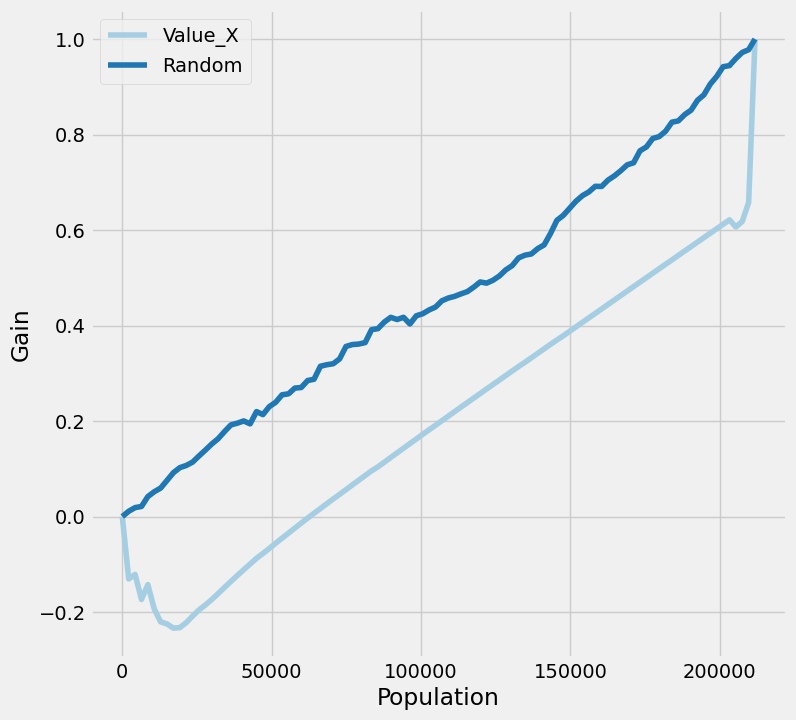

In [14]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =res[['換匯發送名單','TOTALNTAMOUNT',	'Value_X']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=200))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=200)

Gi        0.321666
Random    0.503989
dtype: float64


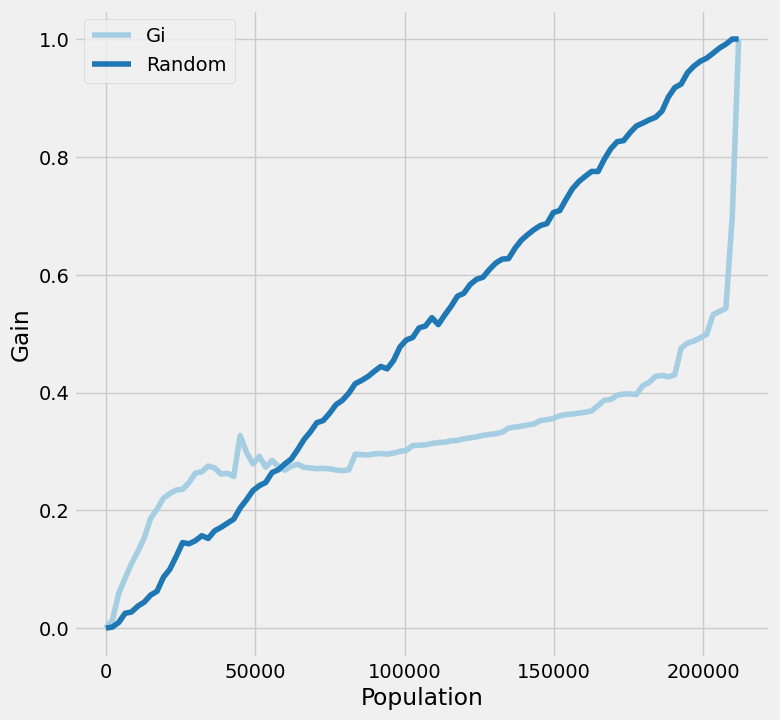

In [15]:
from causalml.metrics import plot_gain, get_cumgain, auuc_score
T =val[['換匯發送名單','TOTALNTAMOUNT',	'Gi']]
print(auuc_score(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42))
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42)

In [ ]:
val

,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,X_te,X_te_2,"E(V)|T = 0, D = 1","E(V)|T = 1, D = 1",Gi,Value_X
0,6.9036,0.0,0.0,0.0,0.004841,0.009918,134.739667,6042.417742,5907.678075,395.603458
1,0.0000,0.0,0.0,0.0,0.007362,0.013521,268.335863,4857.904615,4589.568753,492.010446
2,47.7786,0.0,0.0,0.0,0.004858,0.009952,216.163045,3594.963667,3378.800621,224.099393
3,11.2181,0.0,0.0,0.0,0.002281,0.015855,214.301089,5049.173299,4834.872210,223.496640
4,1.1168,0.0,0.0,0.0,0.004846,0.011726,162.333688,4657.686620,4495.352932,223.412998
...,...,...,...,...,...,...,...,...,...,...
210629,52.9314,0.0,0.0,0.0,0.004852,0.009937,209.045612,4300.509285,4091.463673,223.819211
210630,70.3247,0.0,0.0,0.0,0.000340,-0.001600,367.877158,3320.586524,2952.709366,226.095746
210631,6.2637,0.0,0.0,0.0,0.004841,0.009919,122.458768,5093.697147,4971.238379,223.356830
210632,44.5523,0.0,0.0,0.0,0.005380,0.013429,279.411294,2800.847078,2521.435784,225.463094


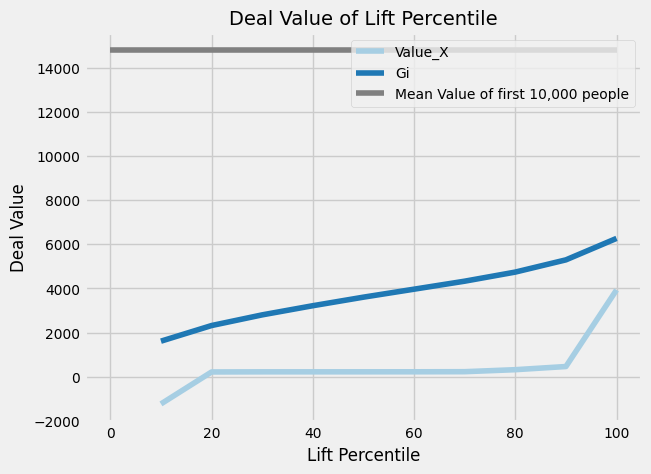

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 根据不同列值排序的字典
columns_to_sort = {
   "Value_X": "Value_X",
   "Gi": "Gi"
}

# 计算Lift值的百分位数
percentiles = range(10, 110, 10)

# 创建字典用于存储不同列的成交率
conversion_rates = {column: [] for column in columns_to_sort}

for col, label in columns_to_sort.items():
   for percentile in percentiles:
       lower_bound = np.percentile(val[col], percentile - 10)
       upper_bound = np.percentile(val[col], percentile)
       subset = val[(val[col] <= upper_bound) & (val[col] > lower_bound)]
       conversion_rate = (subset[col].sum()/len(subset))
       conversion_rates[label].append(conversion_rate)

# 前5000人跨售金額平均
S = val['TOTALNTAMOUNT'].sort_values(ascending=False)[:10000].mean()

# 绘制折线图
fig, ax = plt.subplots()
for label, rates in conversion_rates.items():
   ax.plot(percentiles, rates, label=label)

ax.hlines(y=S, xmin=0.0, xmax=100, color='grey', label='Mean Value of first 10,000 people')
plt.legend(fontsize=10, loc="upper right")
plt.xlabel("Lift Percentile", fontsize = 12)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel("Deal Value", fontsize = 12)
plt.title("Deal Value of Lift Percentile", fontsize = 14)
plt.show()

In [ ]:
import pandas as pd
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_All_202308_new.csv', index_col = 0)
res

,UNINO,換匯基因標籤,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|T = 0, D = 1",te,X_te_2,"E(V)|X,T = 0","E(V)|X,T = 1",Gi,Value_X
0,A1521309050,0.0059,0.001373,0.048074,0.046701,0.004857,88067.946333,-18086.505294,0.011754,120.900778,3364.284911,3243.384134,223.705913
1,A1521310270,43.1608,0.003127,0.043591,0.040463,0.005268,68208.224027,-16562.628867,0.012860,213.316467,2251.258464,2037.941997,225.402402
2,A1521312590,2.4923,0.001788,0.050031,0.048243,0.004894,91168.411721,-17048.049118,0.011814,162.978677,3708.299031,3545.320354,224.873296
3,A1521318940,66.0665,0.002848,0.056080,0.053232,0.006392,103617.724284,-17359.005021,0.016154,295.100096,4837.414952,4542.314857,491.291660
4,A1521321420,15.3138,0.001631,0.062387,0.060756,0.001691,118600.440766,-19618.657805,0.014543,193.417067,6175.182307,5981.765239,223.320797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054428,Y2729821390,0.0000,0.003953,0.037444,0.033491,0.006932,111131.614951,-18184.741163,0.007109,439.356425,3480.311736,3040.955312,488.858419
1054429,Y2729821750,86.4484,0.004097,0.034036,0.029939,0.004487,111857.440722,-27972.861372,0.009792,458.271388,2855.056602,2396.785214,460.483859
1054430,Y2729823350,25.8643,0.001663,0.055808,0.054145,0.004845,135709.481509,-19017.106024,0.011421,225.692785,6512.316657,6286.623872,55.533310
1054431,Y2729824530,0.0000,0.005949,0.037284,0.031335,0.002764,41756.854031,-16981.356344,-0.000560,248.414134,923.727788,675.313654,343.290662


In [ ]:
import pandas as pd
buy = pd.read_csv('/content/drive/MyDrive/Sinopac/11月外匯名單_成效追蹤_資料清理.csv', index_col = 0)
buy

,UNINO,發送名單,標籤,跨售名單,TIMESTAMP,TOTALNTAMOUNT
0,19109226PI0,1,數位通路_換匯名單_A群,0.0,0,0.0
1,A1022923640,0,數位通路_換匯名單_F群,0.0,0,0.0
2,A1220040150,0,數位通路_換匯名單_F群,0.0,0,0.0
3,A1220046320,0,數位通路_換匯名單_F群,0.0,0,0.0
4,A1220094020,0,數位通路_換匯名單_F群,0.0,0,0.0
...,...,...,...,...,...,...
103919,Z2229905650,1,數位通路_換匯名單_G群,0.0,0,0.0
103920,Z2229981590,1,數位通路_換匯名單_F群,0.0,0,0.0
103921,Z2229993230,1,數位通路_換匯名單_F群,0.0,0,0.0
103922,Z2229996730,0,數位通路_換匯名單_F群,0.0,0,0.0


In [ ]:
b = buy[['UNINO','發送名單', '跨售名單', 'TOTALNTAMOUNT']]
final = pd.merge(res, b, on=['UNINO'], how='left')
final = final.fillna(0)
final

,UNINO,換匯基因標籤,Uplift_mean|T = 0,Uplift_mean|T = 1,Uplift_mean,X_te,"E(V)|T = 0, D = 1",te,X_te_2,"E(V)|X,T = 0","E(V)|X,T = 1",Gi,Value_X,發送名單,跨售名單,TOTALNTAMOUNT
0,A1521309050,0.0059,0.001373,0.048074,0.046701,0.004857,88067.946333,-18086.505294,0.011754,120.900778,3364.284911,3243.384134,223.705913,0.0,0.0,0.0
1,A1521310270,43.1608,0.003127,0.043591,0.040463,0.005268,68208.224027,-16562.628867,0.012860,213.316467,2251.258464,2037.941997,225.402402,0.0,0.0,0.0
2,A1521312590,2.4923,0.001788,0.050031,0.048243,0.004894,91168.411721,-17048.049118,0.011814,162.978677,3708.299031,3545.320354,224.873296,0.0,0.0,0.0
3,A1521318940,66.0665,0.002848,0.056080,0.053232,0.006392,103617.724284,-17359.005021,0.016154,295.100096,4837.414952,4542.314857,491.291660,0.0,0.0,0.0
4,A1521321420,15.3138,0.001631,0.062387,0.060756,0.001691,118600.440766,-19618.657805,0.014543,193.417067,6175.182307,5981.765239,223.320797,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054428,Y2729821390,0.0000,0.003953,0.037444,0.033491,0.006932,111131.614951,-18184.741163,0.007109,439.356425,3480.311736,3040.955312,488.858419,0.0,0.0,0.0
1054429,Y2729821750,86.4484,0.004097,0.034036,0.029939,0.004487,111857.440722,-27972.861372,0.009792,458.271388,2855.056602,2396.785214,460.483859,0.0,0.0,0.0
1054430,Y2729823350,25.8643,0.001663,0.055808,0.054145,0.004845,135709.481509,-19017.106024,0.011421,225.692785,6512.316657,6286.623872,55.533310,0.0,0.0,0.0
1054431,Y2729824530,0.0000,0.005949,0.037284,0.031335,0.002764,41756.854031,-16981.356344,-0.000560,248.414134,923.727788,675.313654,343.290662,0.0,0.0,0.0


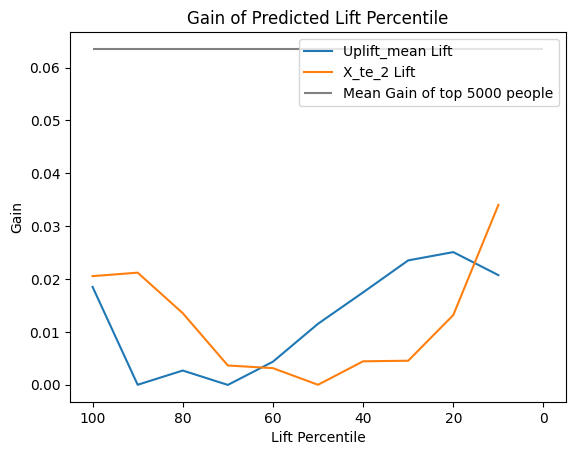

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_lift_gain_curve(data, uplift_columns, target_column, treatment_column, top_k=5000):
    # Create a DataFrame to store results
    results = pd.DataFrame(index=range(10, 110, 10))
    for uplift_column in uplift_columns:
        # Sort data based on uplift_column
        sorted_data = data.sort_values(by=uplift_column, ascending=False)
        # Calculate gain for different percentiles
        conversion_rates = []
        random_gains = []
        for percentile in range(10, 110, 10):
            lower_bound = np.percentile(sorted_data[uplift_column], percentile - 10)
            upper_bound = np.percentile(sorted_data[uplift_column], percentile)
            subset = sorted_data[(sorted_data[uplift_column] <= upper_bound) & (sorted_data[uplift_column] > lower_bound)]
            treatment_subset = subset[subset[treatment_column] == 1]
            control_subset = subset[subset[treatment_column] == 0]
            conversion_rate = ((treatment_subset[target_column].sum() / len(treatment_subset)) - (control_subset[target_column].sum() / len(control_subset)))
            conversion_rates.append(conversion_rate)
        # Store results in the DataFrame
        results[uplift_column + '_Lift'] = conversion_rates
        # Calculate mean gain
        top_k_data = sorted_data.head(top_k)
        treatment_gain = top_k_data[top_k_data[treatment_column] == 1][target_column].mean()
        control_gain = top_k_data[top_k_data[treatment_column] == 0][target_column].mean()
        gain = treatment_gain - control_gain

    # Plot the lift and random gain curves
    fig, ax = plt.subplots()
    for uplift_column in uplift_columns:
        ax.plot(results.index, results[uplift_column + '_Lift'], label=f'{uplift_column} Lift')
    ax.hlines(y=gain, xmin=0.0, xmax=100, color='grey', label=f'Mean Gain of top {top_k} people')
    plt.legend(fontsize=10, loc="upper right")
    plt.xlabel("Lift Percentile")
    plt.ylabel("Gain")
    plt.title("Gain of Predicted Lift Percentile")
    plt.gca().invert_xaxis()  # Invert x-axis to have higher percentiles on the left
    plt.show()

# Example usage:
plot_lift_gain_curve(final, ['Uplift_mean', 'X_te_2'], '跨售名單', '發送名單', top_k=5000)

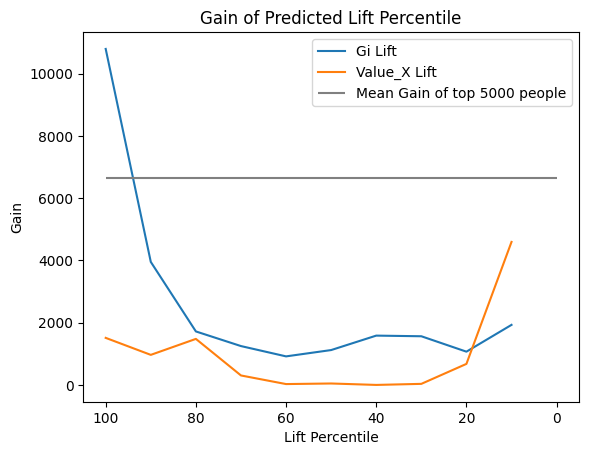

In [ ]:
plot_lift_gain_curve(final, ['Gi', 'Value_X'], 'TOTALNTAMOUNT', '發送名單', top_k=5000)